In [1]:
# import package
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import sleep
from os import listdir
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation as FA

1. Data Processing

In [2]:
col_names = ['unit', 'time', 'os1', 'os2', 'os3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [3]:
dir_path = './data/CMAPSSData/'
df_train = pd.read_csv((dir_path+'train_FD001.txt'), sep=" ", header=None, names=col_names)
df_test = pd.read_csv((dir_path+'test_FD001.txt'), sep=" ", header=None, names=col_names)
rul_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep=" ", header=None, names=['RUL'])

In [4]:
# append RUL value
rul_value = []

for n in np.arange(1,101):

    time_list = np.array(df_train[df_train['unit'] == n]['time'])
    length = len(time_list)
    rul = list(length - time_list)
    rul_value += rul

df_train['rul'] = rul_value

rul_value = []

for n in np.arange(1,101):

    time_list = np.array(df_test[df_test['unit'] == n]['time'])
    length = len(time_list)
    rul_val = rul_test.iloc[n-1].item()
    rul = list(length - time_list + rul_val)
    rul_value += rul

df_test['rul'] = rul_value

for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


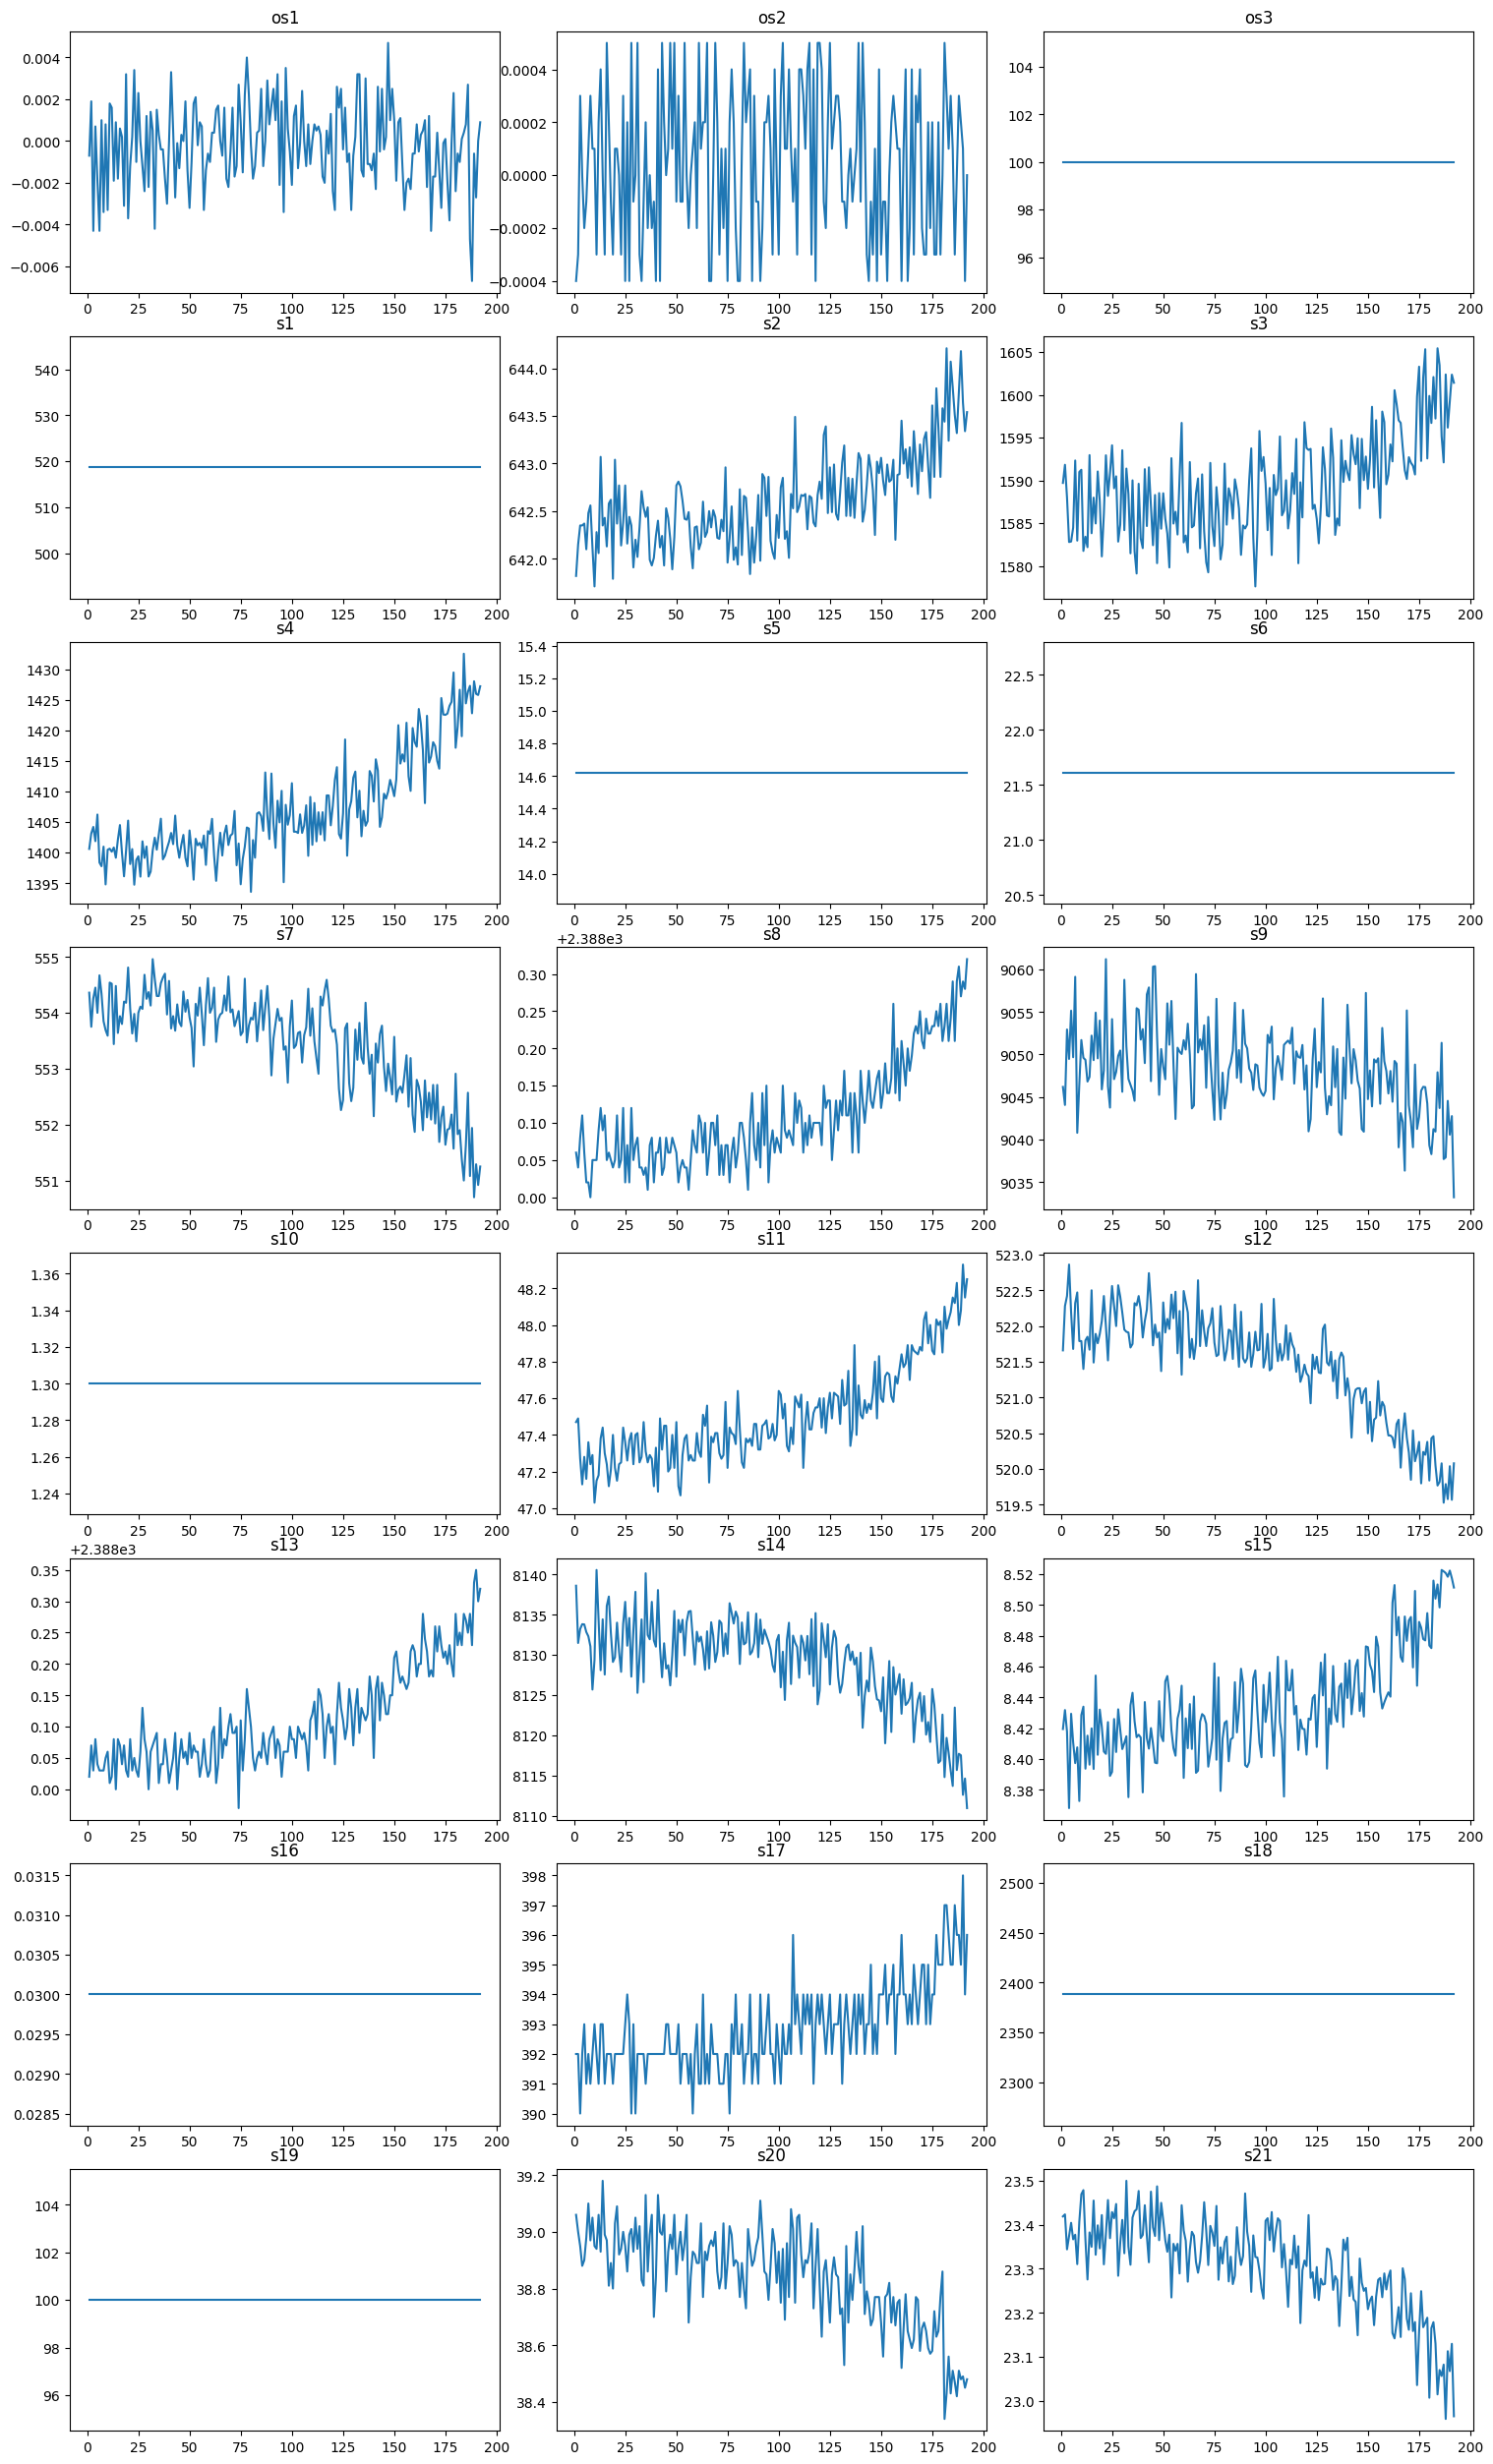

In [5]:
# the trend of sample 1
sample = 1
sample_df = df_train[df_train['unit'] == sample].copy()

fig, axes = plt.subplots(8,3, figsize = (15,25))
fig.tight_layout()

j = -1
for c in df_train.columns:

    if 's' in c:
        j += 1
        axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c])
        axes[j // 3, j % 3].set_title(c)

In [6]:
# Some operational setting or sensor measurement don't have the variety so should observe the statistic
df_train[['os3','s1','s5','s6','s10','s16','s18','s19']].describe()

,os3,s1,s5,s6,s10,s16,s18,s19
count,20631.0,20631.00,2.063100e+04,20631.000000,20631.0,2.063100e+04,20631.0,20631.0
mean,100.0,518.67,1.462000e+01,21.609803,1.3,3.000000e-02,2388.0,100.0
std,0.0,0.00,1.776400e-15,0.001389,0.0,1.387812e-17,0.0,0.0
min,100.0,518.67,1.462000e+01,21.600000,1.3,3.000000e-02,2388.0,100.0
25%,100.0,518.67,1.462000e+01,21.610000,1.3,3.000000e-02,2388.0,100.0
50%,100.0,518.67,1.462000e+01,21.610000,1.3,3.000000e-02,2388.0,100.0
75%,100.0,518.67,1.462000e+01,21.610000,1.3,3.000000e-02,2388.0,100.0
max,100.0,518.67,1.462000e+01,21.610000,1.3,3.000000e-02,2388.0,100.0


In [7]:
# std of these value is very low so can delete these value
drop_cols = ['os3','s1','s5','s6','s10','s16','s18','s19']

df_train = df_train.drop(drop_cols, axis = 1)
df_test = df_test.drop(drop_cols, axis = 1)

for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138


In [8]:
# Min-Max scaled
minmax_dict = {}

for c in df_train.columns:
    if 's' in c:
        minmax_dict[c+'min'] = df_train[c].min()
        minmax_dict[c+'max']=  df_train[c].max()

for c in df_train.columns:
    if 's' in c:
        df_train[c] = (df_train[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])

for c in df_test.columns:
    if 's' in c:
        df_test[c] = (df_test[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])

for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.632184,0.750000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,142
1,1,2,0.344828,0.250000,0.150602,0.379551,0.222316,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827,141
2,1,3,0.517241,0.583333,0.376506,0.346632,0.322248,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348,140
3,1,4,0.741379,0.500000,0.370482,0.285154,0.408001,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110,139
4,1,5,0.580460,0.500000,0.391566,0.352082,0.332039,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377,138


In [9]:
# there is noise in the time series, so a noise reduction function is constructed (Smoothing Function: Exponentially Weighted Averages)
def smooth(s, b = 0.98):

    v = np.zeros(len(s)+1)
    bc = np.zeros(len(s)+1)

    for i in range(1, len(v)):
        v[i] = (b * v[i-1] + (1-b) * s[i-1])
        bc[i] = 1 - b**i

    sm = v[1:] / bc[1:]

    return sm

In [10]:
for c in df_train.columns:

    if 's' in c:
        sm_list = []

        for n in np.arange(1,101):
            s = np.array(df_train[df_train['unit'] == n][c].copy())
            sm = list(smooth(s, 0.98))
            sm_list += sm

        df_train[c+'_smoothed'] = sm_list

for c in df_test.columns:

    if 's' in c:
        sm_list = []

        for n in np.arange(1,101):
            s = np.array(df_test[df_test['unit'] == n][c].copy())
            sm = list(smooth(s, 0.98))
            sm_list += sm

        df_test[c+'_smoothed'] = sm_list

In [ ]:
sample = 1
sample_df = df_train[df_train['unit'] == sample].copy()

fig, axes = plt.subplots(6,3, figsize = (15,25))
fig.tight_layout()

j = -1
for c in df_train.columns:

    if ('s' in c) and ('smoothed' not in c):
        j += 1
        axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c], c = 'dodgerblue', label = 'original')
        axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c+'_smoothed'], c = 'lightcoral', label = 'smoothed')
        axes[j // 3, j % 3].plot([10,10],[0,1], c = 'black')
        axes[j // 3, j % 3].set_title(c)
        axes[j // 3, j % 3].legend()

In [12]:
# remove the original series

for c in df_train.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_train[c] = df_train[c+'_smoothed']
        df_train.drop(c+'_smoothed', axis = 1, inplace = True)

for c in df_test.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_test[c] = df_test[c+'_smoothed']
        df_test.drop(c+'_smoothed', axis = 1, inplace = True)

for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.535237,0.208754,0.233936,0.430144,0.331412,0.676638,0.227120,0.104951,0.375060,0.700028,0.243018,0.181025,0.387888,0.333333,0.689688,0.727870,190
2,1,3,0.439208,0.392826,0.271154,0.409527,0.344714,0.688033,0.242630,0.116885,0.332528,0.732432,0.235390,0.177885,0.377535,0.276652,0.668677,0.691652,189
3,1,4,0.465234,0.420437,0.289760,0.370016,0.341231,0.701612,0.262094,0.118852,0.289798,0.772801,0.250520,0.177113,0.323193,0.291254,0.644194,0.684112,188
4,1,5,0.449741,0.402305,0.302174,0.346587,0.354428,0.694673,0.258000,0.125327,0.282753,0.767278,0.247350,0.176618,0.339614,0.317360,0.632735,0.688357,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.632184,0.750000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,142
1,1,2,0.487054,0.497475,0.345899,0.345454,0.245626,0.729436,0.189164,0.137245,0.298521,0.693438,0.242870,0.168831,0.260578,0.375421,0.620781,0.674457,141
2,1,3,0.497321,0.526674,0.356308,0.345854,0.271685,0.714661,0.202125,0.144331,0.328579,0.695452,0.235292,0.164345,0.327936,0.389448,0.657477,0.690404,140
3,1,4,0.560197,0.519802,0.359960,0.330216,0.306804,0.705615,0.200797,0.134383,0.309869,0.664050,0.239081,0.165825,0.309667,0.353523,0.659845,0.683115,139
4,1,5,0.564415,0.515680,0.366539,0.334768,0.312057,0.703206,0.193692,0.127725,0.302363,0.679389,0.235232,0.163103,0.307839,0.314626,0.659651,0.690038,138


In [13]:
# analyze the time cycles of train set and test set
print('training set time cycles:')
display(df_train.groupby('unit')['time'].max().describe())
print('test set time cycles:')
display(df_test.groupby('unit')['time'].max().describe())

training set time cycles:


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time, dtype: float64

test set time cycles:


count    100.000000
mean     130.960000
std       53.593479
min       31.000000
25%       88.750000
50%      133.500000
75%      164.250000
max      303.000000
Name: time, dtype: float64

In [22]:
device = "cpu"

In [23]:
n_features = len([c for c in df_train.columns if 's' in c])
window = 20
print(f'number of features: {n_features}, window size: {window}')

number of features: 16, window size: 20


In [24]:
# splitting Train and Validation Sets
np.random.seed(5)
units = np.arange(1,101)
train_units = list(np.random.choice(units, 80, replace = False))
val_units = list(set(units) - set(train_units))
print(val_units)

[8, 9, 16, 17, 28, 31, 45, 54, 62, 63, 66, 74, 76, 77, 78, 79, 81, 91, 93, 100]


In [25]:
train_data = df_train[df_train['unit'].isin(train_units)].copy()
val_data = df_train[df_train['unit'].isin(val_units)].copy()

train_indices = list(train_data[(train_data['rul'] >= (window - 1)) & (train_data['time'] > 10)].index)
val_indices = list(val_data[(val_data['rul'] >= (window - 1)) & (val_data['time'] > 10)].index)

In [26]:
# prepare Training, Validation and Test Dataloaders
class data(Dataset):

    def __init__(self, list_indices, df_train):

        self.indices = list_indices
        self.df_train = df_train

    def __len__(self):

        return len(self.indices)

    def __getitem__(self, idx):

        ind = self.indices[idx]
        X_ = self.df_train.iloc[ind : ind + 20, :].drop(['time','unit','rul'], axis = 1).copy().to_numpy()
        y_ = self.df_train.iloc[ind + 19]['rul']

        return X_, y_

torch.manual_seed(5)

train = data(train_indices, df_train)
val = data(val_indices, df_train)

trainloader = DataLoader(train, batch_size = 64, shuffle = True)
valloader = DataLoader(val, batch_size = len(val_indices), shuffle = True)

units = np.arange(1,101)

class test(Dataset):

    def __init__(self, units, df_test):

        self.units = units
        self.df_test = df_test

    def __len__(self):

        return len(self.units)

    def __getitem__(self, idx):

        n = self.units[idx]
        U = self.df_test[self.df_test['unit'] == n].copy()
        X_ = U.reset_index().iloc[-20:,:].drop(['index','unit','time','rul'], axis = 1).copy().to_numpy()
        y_ = U['rul'].min()

        return X_, y_

test = test(units, df_test)
testloader = DataLoader(test, batch_size = 100)

2. Model Training

In [27]:
# LSTM building
class LSTMRegressor(nn.Module):

    def __init__(self, n_features, hidden_units):
        super().__init__()
        self.n_features = n_features
        self.hidden_units = hidden_units
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size = n_features, hidden_size = self.hidden_units, batch_first = True, num_layers = self.n_layers)
        self.linear1 = nn.Linear(in_features=self.hidden_units, out_features=12)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=12, out_features=12)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(in_features=12, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear1(hn[0])
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out).flatten()

        return out

learning_rate = 0.001
n_hidden_units = 12

torch.manual_seed(15)

model = LSTMRegressor(n_features, n_hidden_units).to(device)
loss_fn = nn.MSELoss()
loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
ks = [key for key in model.state_dict().keys() if 'linear' in key and '.weight' in key]

for k in ks:
    nn.init.kaiming_uniform_(model.state_dict()[k])

bs = [key for key in model.state_dict().keys() if 'linear' in key and '.bias' in key]

for b in bs:
    nn.init.constant_(model.state_dict()[b], 0)

In [28]:
def validation():
    model.eval()
    X, y = next(iter(valloader))
    X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)

    with torch.no_grad():
        y_pred = model(X)
        val_loss = loss_fn(y_pred, y).item()

    return val_loss

loss_L1 = nn.L1Loss()

def test():
    model.eval()
    X, y = next(iter(testloader))
    X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)

    with torch.no_grad():
        y_pred = model(X)
        test_loss_MSE = loss_fn(y_pred, y).item()
        test_loss_L1 = loss_L1(y_pred, y).item()

        ss_res = torch.sum((y - y_pred) ** 2)
        y_mean = torch.mean(y)
        ss_tot = torch.sum((y - y_mean) ** 2)
        r2 = 1 - ss_res / ss_tot

    return test_loss_MSE, test_loss_L1, r2.item(), y_pred, y

In [29]:
T = []
V = []

epochs = 100

model.train()

for i in tqdm(range(epochs)):

    L = 0

    for batch, (X,y) in enumerate(trainloader):

        X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        L += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    val_loss = validation()

    T.append(L/len(trainloader))
    V.append(val_loss)

    if (i+1) % 10 == 0:
        sleep(0.5)
        print(f'epoch:{i+1}, avg_train_loss:{L/len(trainloader)}, val_loss:{val_loss}')

        model.train()

 10%|█         | 10/100 [02:55<26:11, 17.46s/it]

epoch:10, avg_train_loss:1661.7950571785987, val_loss:1009.6107788085938


 20%|██        | 20/100 [05:43<22:13, 16.67s/it]

epoch:20, avg_train_loss:915.6947866794283, val_loss:877.4769287109375


 30%|███       | 30/100 [08:26<19:04, 16.35s/it]

epoch:30, avg_train_loss:789.4717630031889, val_loss:663.0055541992188


 40%|████      | 40/100 [11:09<16:27, 16.45s/it]

epoch:40, avg_train_loss:765.1303642070399, val_loss:729.855712890625


 50%|█████     | 50/100 [13:54<14:14, 17.08s/it]

epoch:50, avg_train_loss:724.309737484012, val_loss:837.3925170898438


 60%|██████    | 60/100 [17:02<12:46, 19.16s/it]

epoch:60, avg_train_loss:702.8981823710213, val_loss:1018.8368530273438


 70%|███████   | 70/100 [20:10<09:26, 18.90s/it]

epoch:70, avg_train_loss:703.0183623997511, val_loss:754.5778198242188


 80%|████████  | 80/100 [23:37<07:05, 21.30s/it]

epoch:80, avg_train_loss:659.5737593659258, val_loss:725.4412231445312


 90%|█████████ | 90/100 [27:13<03:36, 21.63s/it]

epoch:90, avg_train_loss:592.8927509679204, val_loss:595.2562255859375


100%|██████████| 100/100 [30:49<00:00, 18.49s/it]

epoch:100, avg_train_loss:570.2128351262186, val_loss:627.977783203125


In [31]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
model.

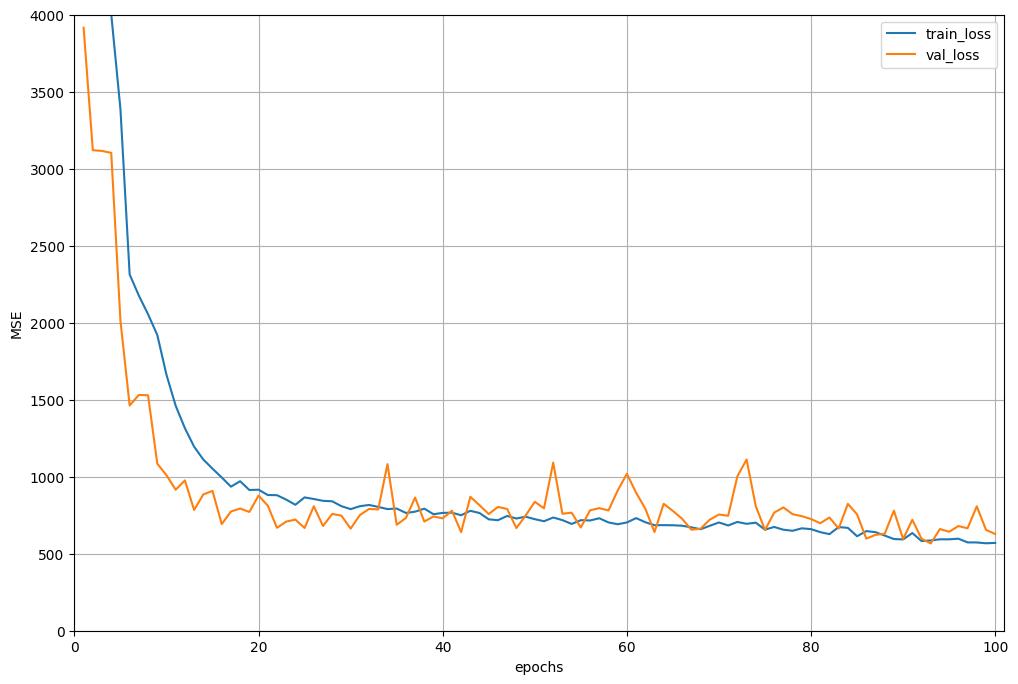

In [30]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(np.arange(1, len(T)+1), T, label='train_loss')
ax.plot(np.arange(1, len(V)+1), V, label='val_loss')

ax.legend()
ax.grid(True)
ax.set_xlim(0, 101)
ax.set_ylim(0, 4000)
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')

plt.show()

3. Prediction on Test Set

In [ ]:
mse, l1, r2, y_pred, y = test()

print(f'Test MSE:{round(mse,2)}, L1:{round(l1,2)}, R2:{round(r2,2)}')

Test MSE:664.61, L1:17.71, R2:0.62


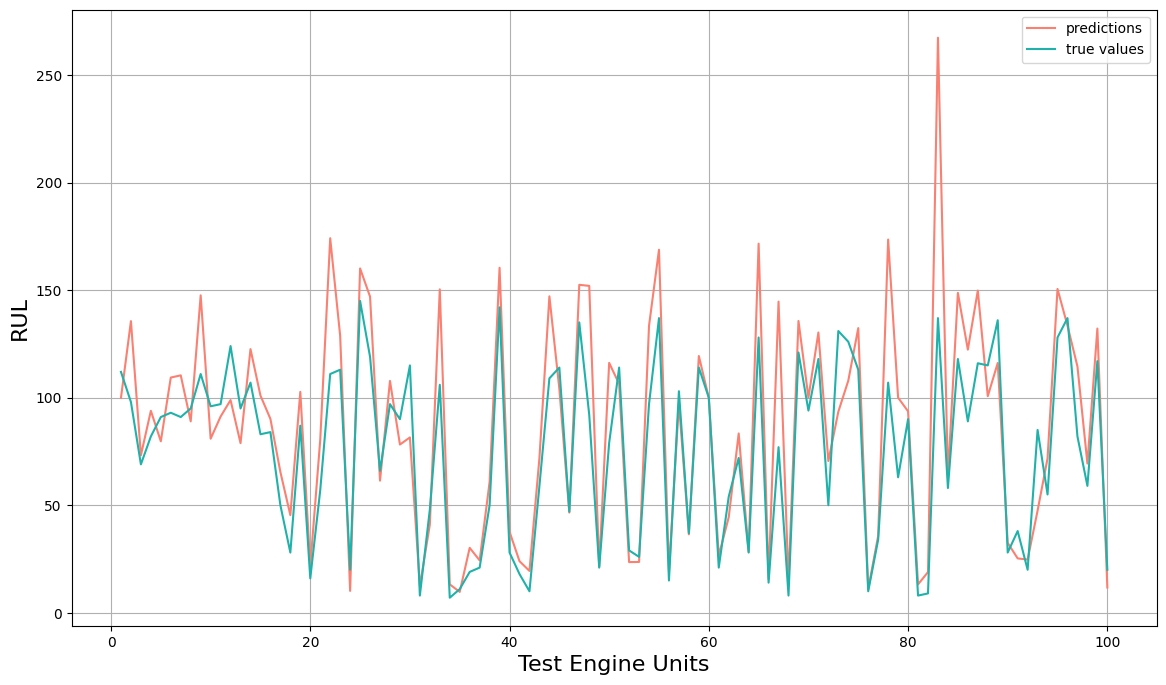

In [ ]:
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(np.arange(1,101), y_pred.numpy(), label = 'predictions', c = 'salmon')
ax.plot(np.arange(1,101), y.numpy(), label = 'true values', c = 'lightseagreen')
ax.set_xlabel('Test Engine Units', fontsize = 16)
ax.set_ylabel('RUL', fontsize = 16)
ax.grid(True)
ax.legend()
plt.show()

In [4]:
# Example: reuse your existing OpenAI setup
from openai import OpenAI

# Point to the local server
client = OpenAI(base_url="http://localhost:8189/v1", api_key="lm-studio")

completion = client.chat.completions.create(
  model="Microsoft/phi-3",
  messages=[
    {"role": "system", "content": "Answer a given question"},
    {"role": "user", "content": "Who are you and who designed you?"}
  ],
  temperature=1,
)

print(completion.choices[0].message.content)

I am Phi, an AI created by Microsoft.<|end|><|assistant|> Certainly! Here's the response to your query:

"Hello! I am Phi, which is part of a suite of intelligent services developed under the guidance of Microsoft."<|end|>
